Este colab fue desarrollado por Arnold Charry Armero.

# Extremely Randomized Trees (Clasificación)

El algoritmo Extremely Randomized Trees (Extra Trees) es un método de ensamble basado en la construcción de múltiples árboles de decisión. Su funcionamiento es muy similar al de Random Forest, ya que ambos combinan muchos árboles entrenados sobre distintos subconjuntos de características para mejorar la generalización del modelo y reducir la varianza.

La diferencia clave radica en el nivel de aleatoriedad introducido durante la construcción de los árboles:

*   En Random Forest, cada nodo se divide buscando el punto de corte óptimo (el umbral que maximiza la reducción de impureza) dentro de un subconjunto aleatorio de características.
*   En Extra Trees, además de seleccionar aleatoriamente las características, los puntos de corte también se eligen de manera completamente aleatoria, sin buscar el umbral óptimo.

Para cada característica seleccionada, el algoritmo genera un único punto de corte aleatorio (por ejemplo, un valor entre el mínimo y máximo de esa variable en el nodo actual). Luego, evalúa cada uno de esos cortes aleatorios calculando la reducción de impureza (por ejemplo, usando el índice de Gini, entropía o varianza) y elige el que produce la mayor ganancia.

Este enfoque hace que Extra Trees sea más rápido que Random Forest, ya que evita el proceso exhaustivo de búsqueda del mejor umbral, y además reduce el riesgo de sobreajuste al introducir más variabilidad entre los árboles.

Finalmente, la predicción del ensamble se obtiene combinando los resultados de todos los árboles:

*   En clasificación, se utiliza la votación mayoritaria entre los árboles.
*   En regresión, se calcula el promedio (o promedio ponderado) de las predicciones individuales.

En resumen, Extra Trees logra un equilibrio entre rapidez, simplicidad y capacidad de generalización, gracias a la fuerte aleatoriedad en la selección de características y puntos de corte

Ahora se continúa con la implementación en código,

In [ ]:
# Se importan las librerias
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from pandas.api.types import is_numeric_dtype, is_object_dtype, is_string_dtype
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Machine Learning/Bases de Datos/penguins_binary_classification.csv')

In [ ]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007


Primero se analiza la base de datos,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            274 non-null    object 
 1   island             274 non-null    object 
 2   bill_length_mm     274 non-null    float64
 3   bill_depth_mm      274 non-null    float64
 4   flipper_length_mm  274 non-null    float64
 5   body_mass_g        274 non-null    float64
 6   year               274 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 15.1+ KB


In [ ]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,274.000000,274.000000,274.000000,274.000000,274.000000
mean,42.702920,16.836131,202.178832,4318.065693,2008.043796
std,5.195566,2.013410,15.047938,835.933105,0.806281
min,32.100000,13.100000,172.000000,2850.000000,2007.000000
25%,38.350000,15.000000,190.000000,3600.000000,2007.000000
50%,42.000000,17.000000,198.000000,4262.500000,2008.000000
75%,46.675000,18.500000,215.000000,4950.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Se contabilizan las especies,

In [ ]:
df['species'].value_counts()

,count
species,
Adelie,151
Gentoo,123


## Preprocesamiento de Datos

Se verifica a ver el tema de los faltantes,

In [ ]:
df.isnull().sum()[df.isnull().sum() != 0]

,0


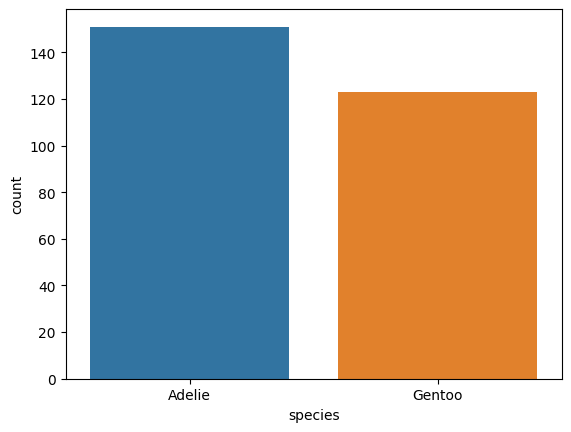

In [ ]:
# Gráfico de barras por cada clase
sns.countplot(data=df,x='species', hue='species')
plt.show()

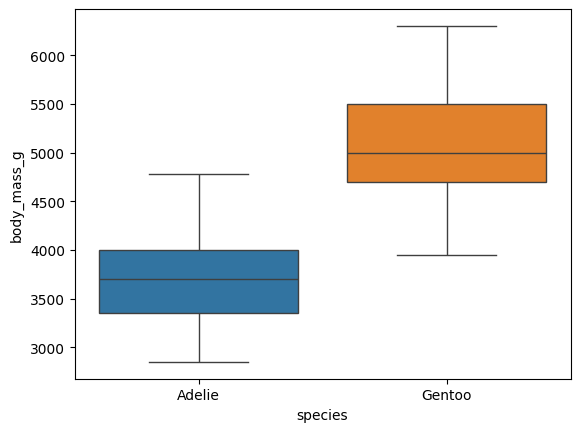

In [ ]:
# Gráfico de caja
sns.boxplot(x='species',y='body_mass_g',data=df, hue='species')
plt.show()

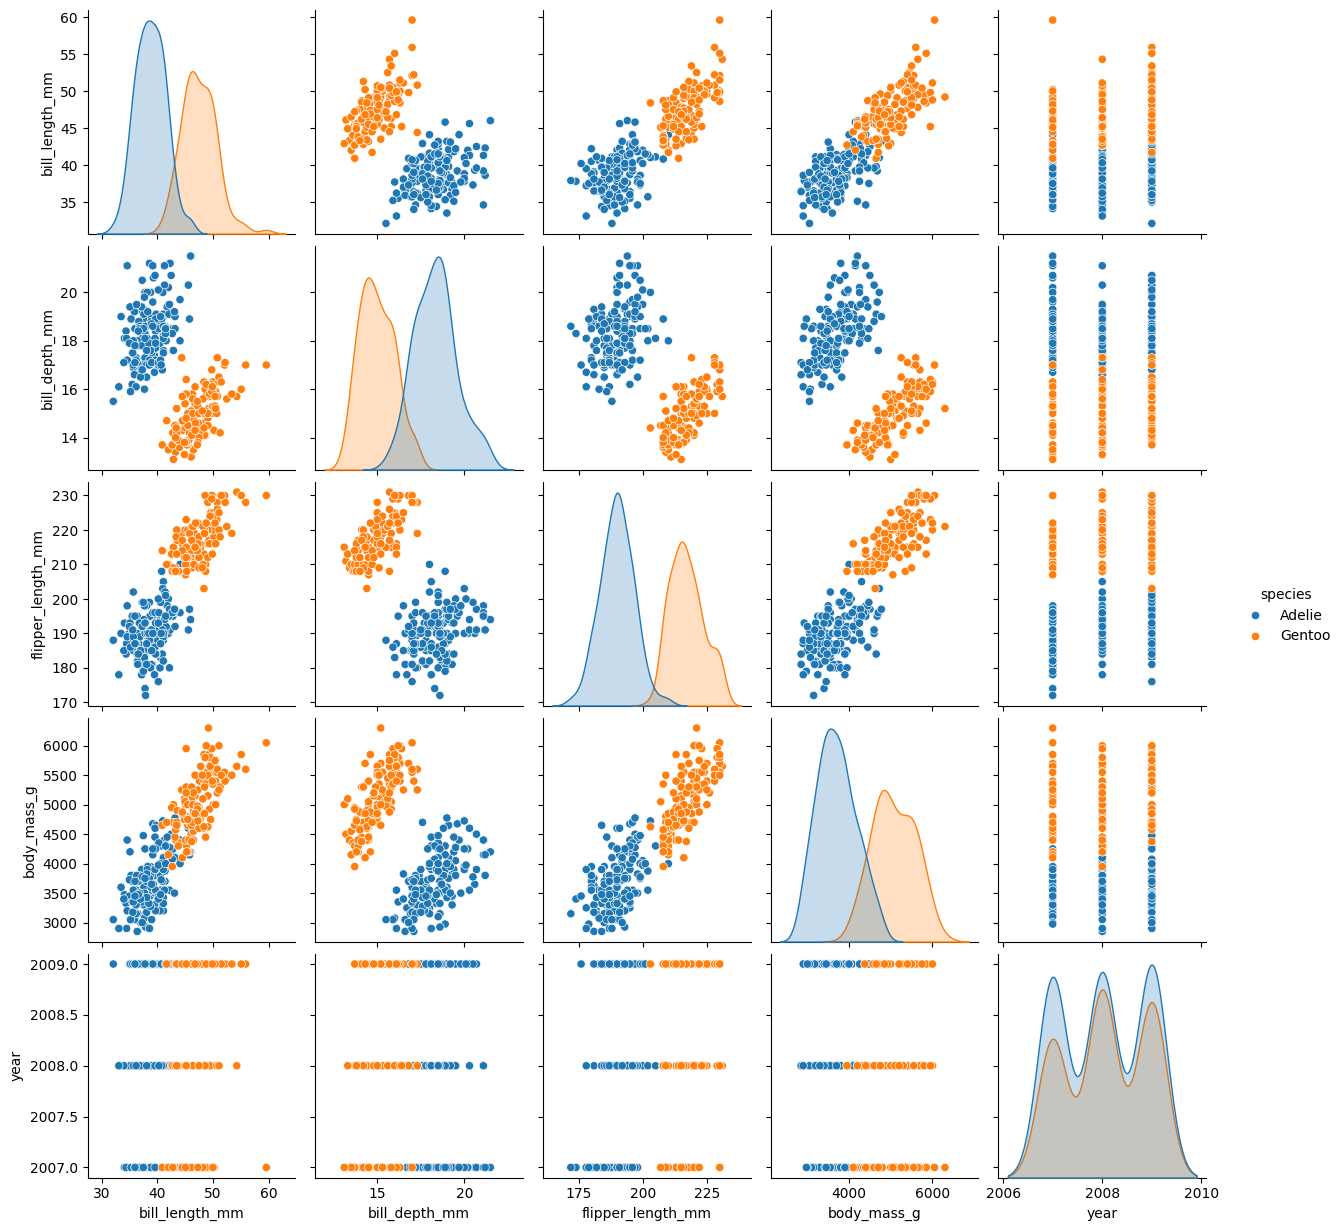

In [ ]:
sns.pairplot(df,hue='species')
plt.show()

Eliminamos la columna del año al no ser relevante,

In [ ]:
df.drop('year', axis = 1, inplace = True)
df.head(274)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0
...,...,...,...,...,...,...
269,Gentoo,Biscoe,47.2,13.7,214.0,4925.0
270,Gentoo,Biscoe,46.8,14.3,215.0,4850.0
271,Gentoo,Biscoe,50.4,15.7,222.0,5750.0
272,Gentoo,Biscoe,45.2,14.8,212.0,5200.0


In [ ]:
# Obtenemos las características
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
# Se detectan las columnas categóricas
cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop(df.columns[0])
cat_indices = [df.columns.get_loc(col) - 1 for col in cat_cols]

# Se detectan las columnas numéricas
num_indices = [i for i in range(df.shape[1] - 1) if i not in cat_indices]

# Se crea el transformador
ct = ColumnTransformer(
    transformers=[('encoder', OneHotEncoder(drop='first',sparse_output=False, dtype=int), cat_indices)],
                    remainder='passthrough')

## Separación en Base de datos de Entrenamiento y Prueba

In [ ]:
# Se divide la base de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Escalado de Datos

In [ ]:
# Se escalan las variables y se hace one-hot encoder
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

In [ ]:
# Visualizar el array X_train
print(X_train)

[[1 0 39.8 19.1 184.0 4650.0]
 [0 0 46.7 15.3 219.0 5200.0]
 [0 0 46.2 14.4 214.0 4650.0]
 ...
 [0 0 38.2 20.0 190.0 3900.0]
 [0 0 46.8 14.3 215.0 4850.0]
 [0 0 37.8 20.0 190.0 4250.0]]


## Entrenamiento del Modelo

Ahora vamos con el modelo ExtraTrees,

In [ ]:
ExtraTrees_model = ExtraTreesClassifier(n_estimators = 100, max_features = "sqrt", random_state = 0)
ExtraTrees_model.fit(X_train, y_train)

ExtraTreesClassifier(random_state=0)

Realizando una predicción,

In [ ]:
# Se debe de hacer en el orden original
print("Predicción:", ExtraTrees_model.predict(ct.transform([['Biscoe', 39.3, 13.7, 195.0, 5750.0]]))[0])

Predicción: Gentoo


In [ ]:
# Obtenemos las predicciones
y_pred = ExtraTrees_model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']]


## Rendimiento del Modelo

In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [ ]:
# Matriz de confusión
confusion_matrix(y_test,y_pred)

array([[48,  0],
       [ 0, 35]])

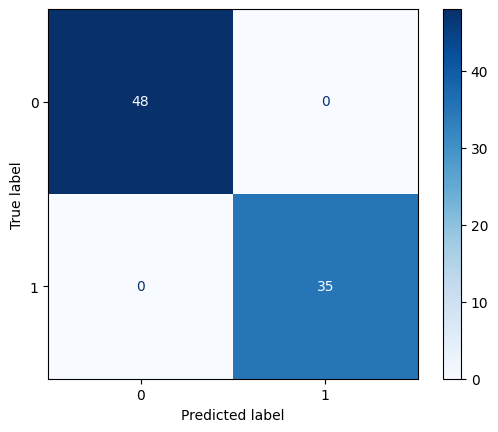

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        48
      Gentoo       1.00      1.00      1.00        35

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



## Validación Cruzada y Grid Search

In [ ]:
# Aplicar K-fold Cross Validation
accuracies = cross_val_score(estimator = ExtraTrees_model, X = X_train, y = y_train, cv = 10, scoring = 'accuracy')
print(accuracies.mean())

1.0


Se conocen los parámetros de ExtraTrees para evaluar el GridSearch.

In [ ]:
ExtraTrees_model = ExtraTreesClassifier(random_state = 0)

In [ ]:
# Parámetros
ExtraTrees_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
# Se establecen los parámetros a probar
parameters = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', 0.33]}

In [ ]:
# Se utiliza GridSearchCV
full_cv_classifier = GridSearchCV(estimator = ExtraTrees_model,
                                  param_grid = parameters,
                                  cv = 10,
                                  scoring = 'accuracy',
                                  n_jobs = -1,
                                  verbose = 2)

In [ ]:
# Se entrena el CV_Classifier
full_cv_classifier.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10, estimator=ExtraTreesClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5, 10, None],
                         'max_features': ['sqrt', 'log2', 0.33],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy', verbose=2)

In [ ]:
print(full_cv_classifier.best_params_)

{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Se obtiene el mejor resultado
print(full_cv_classifier.best_score_)

1.0


Ahora se vuelve a entrenar el modelo, pero con los parámetros óptimos.

In [ ]:
model = ExtraTreesClassifier(n_estimators = 100, max_depth = 5, max_features = 'sqrt', min_samples_leaf = 1,
                              min_samples_split = 2)
model.fit(X_train,y_train)

ExtraTreesClassifier(max_depth=5)

In [ ]:
# Obtenemos las predicciones
y_pred = model.predict(X_test)
print(y_pred.reshape(len(y_pred),1))

[['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Gentoo']
 ['Gentoo']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Adelie']
 ['Gentoo']]


In [ ]:
# Obteniendo la precisión del modelo
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 1.0


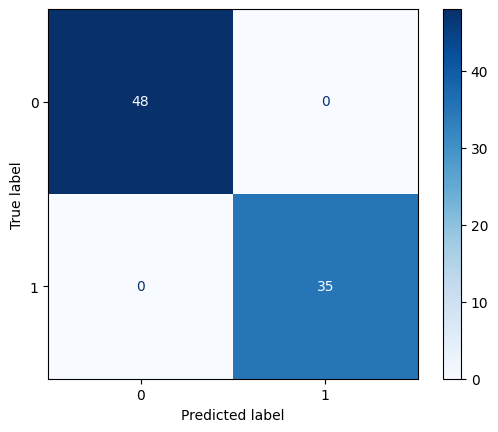

In [ ]:
# Visualizando la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0, 1])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [ ]:
# Obteniendo el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        48
      Gentoo       1.00      1.00      1.00        35

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83



Ahora se miran las características más importantes,

In [ ]:
features = model.feature_importances_[1:]

In [ ]:
feats = pd.DataFrame(index = df.columns[1:], data = features, columns = ["Importance"])

In [ ]:
display(feats)

,Importance
island,0.090534
bill_length_mm,0.177002
bill_depth_mm,0.205262
flipper_length_mm,0.279343
body_mass_g,0.145695


In [ ]:
imp_feats = feats[feats['Importance'] > 0]

In [ ]:
# Ordenar de mayor a menor
imp_feats = imp_feats.sort_values(by='Importance', ascending=False)

Se imprime un gráfico con las características más importantes,

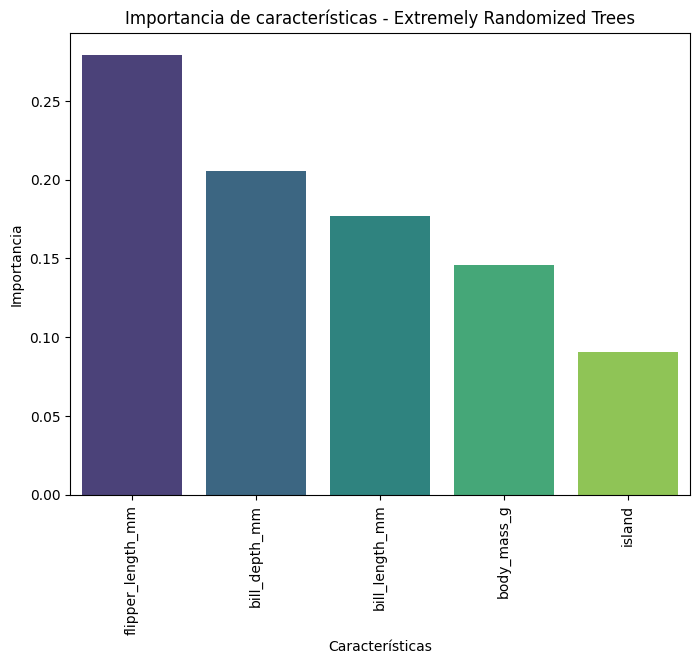

In [ ]:
plt.figure(figsize = (8, 6))
sns.barplot(data = imp_feats, x = imp_feats.index, y = 'Importance', hue = imp_feats.index, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de características - Extremely Randomized Trees")
plt.show()

## Referencias

*   Jacinto, V. R. (2024). Machine learning: Fundamentos, algoritmos y aplicaciones para los negocios, industria y finanzas. Ediciones Díaz de Santos.
*   James, G., Witten, D., Hastie, T., & Tibshirani, R. (2021). An Introduction to Statistical Learning: with Applications in R. https://link.springer.com/content/pdf/10.1007/978-1-0716-1418-1.pdf
*  Palmer Penguins for binary classification. (2023, November 26). Kaggle. https://www.kaggle.com/datasets/martaarroyo/palmer-penguins-for-binary-classification
*   Vandeput, N. (2021). Data science for supply chain forecasting. de Gruyter.